## Collect data from Pylon CCD

First start the image server by running "sudo python Server.py" in the /home/photon/code/Camserver folder

In [5]:
%matplotlib inline

In [59]:
import numpy as np
import os
import zmq
from scipy import stats
from collections import Counter 
from numpy.fft import fft,fftshift
from numpy import real, imag, abs, frombuffer, angle
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
sys.path.append('/home/photon/code/PylonCCD')
import serial
import time

In [7]:
import datetime

In [8]:
mpl.rcParams['figure.figsize'] = (12.0, 6.0)

In [9]:
def qfuncimage(array,bins=10,dolog=False,scaling=1.0):
    x = scaling*np.imag(array) # x is first dim. so imshow has it vertical
    y = scaling*np.real(array) # y is second dim. so imshow has it horizontal

    H, xe, ye = np.histogram2d(x,y,bins)
    extent = [ye[0], ye[-1], xe[0], xe[-1]] # flipped axes since original
    #print extent
    fig = plt.figure()
    ax = plt.gca()
    ax.set_aspect('equal')
    # dolog takes the log of the histogram to show subtle values
    if dolog:
        H = np.log(H+0.1)
    #extent_scaled = [i*scaling for i in extent]
    plt.imshow(H, origin="lower", extent=extent, interpolation='nearest', cmap = 'jet')
    plt.colorbar()
    plt.xticks((ye[-1],0,ye[0]))
    plt.yticks((xe[0],0,xe[-1]))
    plt.xlabel(r'Real($ \alpha $)')
    plt.ylabel(r'Imag($ \alpha $)')
    plt.title("Q function")

    return fig

In [10]:
import Qfunction as Qfunc

In [11]:
def recv_array(socket, flags=0, copy=False, track=False):
    """recv a numpy array"""
    md = socket.recv_json(flags=flags)
    msg = socket.recv(flags=flags, copy=copy, track=track)
    buf = buffer(msg)
    A = frombuffer(buf, dtype=md['dtype'])
    return A.reshape(md['shape'])

In [15]:
REQUEST_TIMEOUT = 25000
SERVER_ENDPOINT = "tcp://localhost:5555"

context = zmq.Context()

#  Socket to talk to server
print "Connecting to array server..."
client = context.socket(zmq.REQ)
client.connect(SERVER_ENDPOINT)

poll = zmq.Poller()
poll.register(client, zmq.POLLIN)

Connecting to array server...


In [16]:
def request_images(client,N=1):
    shots_requested = N
    request = str(shots_requested)  # ask for one shot of data
    #print "I: Sending (%s)" % request
    
    client.send(request)

In [17]:
""" Set up lists to hold the analysis output, only call this cell to clear the data before a new round of collection """
output = []

In [18]:
def open_images():
    socks = dict(poll.poll(REQUEST_TIMEOUT))
    if socks.get(client) == zmq.POLLIN:
        data_array = recv_array(client)
        #reply = client.recv()
    
        if len(data_array) > 1:  # TODO test for the right size array
            #print "I: Server replied OK: " + str(data_array.shape)
            return data_array
    
        else:
            # print "E: Malformed reply from server: %s" % reply
            print "E: no reply from server"
            return -1

In [19]:
def saveQfig(root_path = "/home/photon/Dropbox/Data/"):
    """
    Save Qfig data as .png of qfunc and .npy of array of complex max values of fft's
    Creates a folder with today's date: 01-13-2014
    If folder for today doesn't exist, create it; else navigate to appropriate folder
    """
    target_folder = datetime.datetime.now().strftime("%m-%d-%Y")
    if not os.path.exists(root_path + target_folder):
        os.makedirs(root_path + target_folder)
    os.chdir(root_path + target_folder)
    
    
    filename = datetime.datetime.now().strftime("%H-%M-%S")# based on time and date
    qfig.savefig(filename)
    np.save(filename, output)
    
    print filename

In [20]:
def saveRaw(root_path = "/home/photon/data/"):
    """
    Save Raw zipped data as .npz of array of complex max values of fft's
    Creates a folder with today's date: 01-13-2014
    If folder for today doesn't exist, create it; else navigate to appropriate folder
    """
    target_folder = datetime.datetime.now().strftime("%m-%d-%Y")
    if not os.path.exists(root_path + target_folder):
        os.makedirs(root_path + target_folder)
    os.chdir(root_path + target_folder)
    
    
    filename = datetime.datetime.now().strftime("%H-%M-%S") + "_raw"  # based on time and date
    np.savez(filename, dataOut=dataOut, ncount=ncount)
    
    print filename

In [21]:
import serial

In [22]:
shutter = serial.Serial("/dev/ttyACM0")
def sigOpen():
    # add power control to servo
    # power on
    shutter.write("b\n")
     # step back one to reduce buzz from undershoot
    # power off
    
def sigClose():
    shutter.write("a\n")
 

In [23]:
sigClose()

In [24]:
sigOpen()

## Use these cells to check acquisition etc, and collect BG

In [25]:
request_images(client,N=1)

In [26]:
background = open_images()

In [33]:
request_images(client,N=5)

In [34]:
data = open_images()

In [35]:
corrected = data - background

In [36]:
# calculate power in Watts
corrected.sum() * 2.54704992e-19 / (6e-3 * 5) 

4.497004410770269e-09

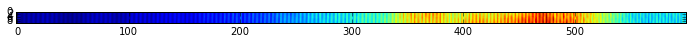

In [37]:
plt.imshow(corrected[:,:,0])

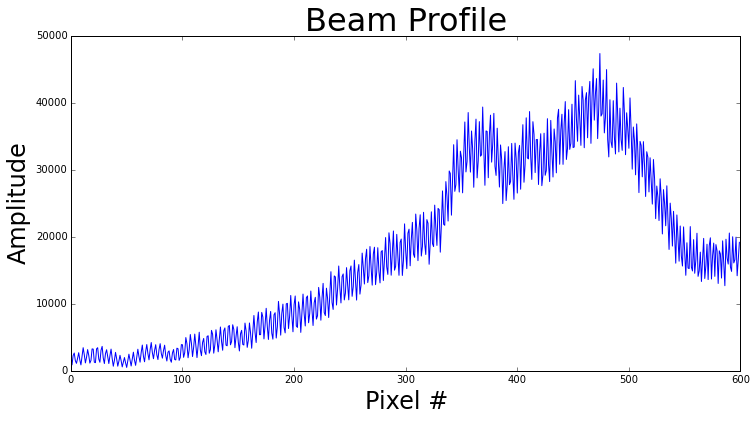

In [38]:
plt.plot(corrected[5,:,0])
#plt.plot(background[5,:,0])
plt.title("Beam Profile", fontsize=32)
plt.xlabel("Pixel #", fontsize=24)
plt.ylabel("Amplitude",fontsize=24)

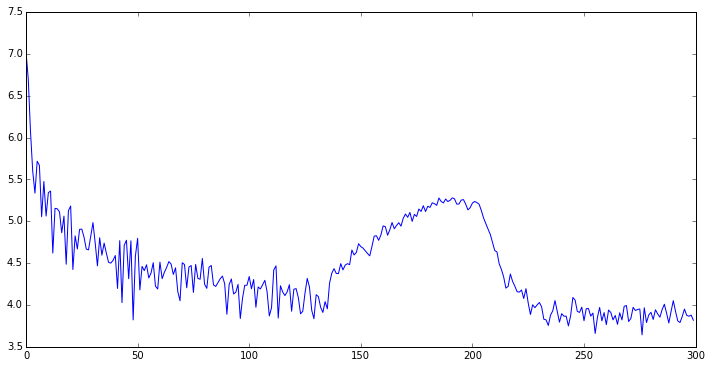

In [39]:
plt.plot(np.log10(abs(fft( np.average(corrected[:,:,0],axis = 0)  )[0:300] )))

# This is the one-cell version:
Starts with a vacuum collection, then does a full data set.

In [85]:
sigClose()
time.sleep(5)
N = 50  # frames to collect (this is sent to the ZMQ server)
M = 10  # rounds of data (total shots is N*M)

dataOut = np.empty([600,N,M],dtype=complex)
ncount = np.empty([N,M])
for i in range(M):
    print "vacuum round: %i" % (i+1)
    request_images(client,N)
    data = open_images()
    frames = data.shape[2]
    ydim = data.shape[0]
    xdim = data.shape[1]
    
    for f in range (0, frames):

        
        BGcorrected = data[:,:,f] - background[:,:,0] # could probably speed this up?
        
        # Track the total power (i.e. sum all photons detected)
        ncount[f,i] = BGcorrected.sum()
    
        # vertical sum over middle 10 rows, then fftshift, then fft:
        dataOut[:,f,i] = fft( fftshift( BGcorrected.sum(axis = 0) ) )
    
print "Finished vacuum"
saveRaw()

vacFFT = np.average(dataOut,axis=(1,2))

sigOpen()
time.sleep(5)
N = 50  # frames to collect (this is sent to the ZMQ server)
M = 10  # rounds of data (total shots is N*M)

dataOut = np.empty([600,N,M],dtype=complex)
ncount = np.empty([N,M])
for i in range(M):
    print "data round: %i" % (i+1)
    request_images(client,N)
    data = open_images()
    frames = data.shape[2]
    ydim = data.shape[0]
    xdim = data.shape[1]
    
    for f in range (0, frames):

        
        BGcorrected = data[:,:,f] - background[:,:,0] # could probably speed this up?
        
        # Track the total power (i.e. sum all photons detected)
        ncount[f,i] = BGcorrected.sum()
    
        # vertical sum over middle 10 rows, then fftshift, then fft:
        dataOut[:,f,i] = fft( fftshift( BGcorrected.sum(axis = 0) ) )
    
print "Finished data"
saveRaw()

vacuum round: 1
vacuum round: 2
vacuum round: 3
vacuum round: 4
vacuum round: 5
vacuum round: 6
vacuum round: 7
vacuum round: 8
vacuum round: 9
vacuum round: 10
Finished vacuum
15-50-27_raw
data round: 1
data round: 2
data round: 3
data round: 4
data round: 5
data round: 6
data round: 7
data round: 8
data round: 9
data round: 10
Finished data
15-50-57_raw


##Log data filenames at this point!

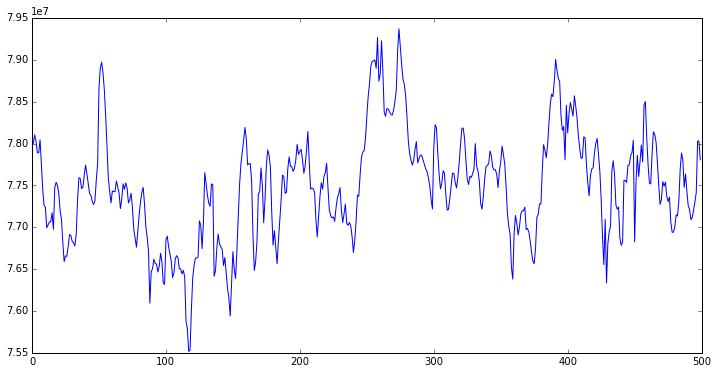

In [87]:
# This should be constant, no big drops or peaks. It is basically a measure of the LO power vs time.
plt.plot(ncount.flatten('F'))

In [88]:
#subtract the vacuum from this data set (if the vacFFT is set)
VacCorrected = dataOut[:,:,:] - vacFFT.reshape(600,1,1)

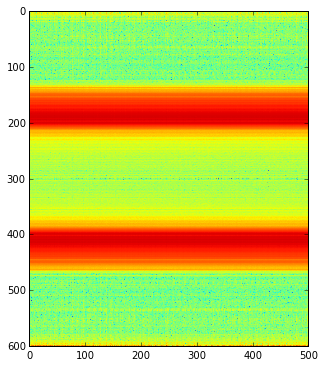

In [89]:
# Look at structure in the VacCorrected array vs. time
# Should be quiet except for where the signal is. Expect some peaks at the top and bottom edges (i.e. near DC)
plt.imshow(np.log10(abs( VacCorrected.reshape(600,M*N) )))

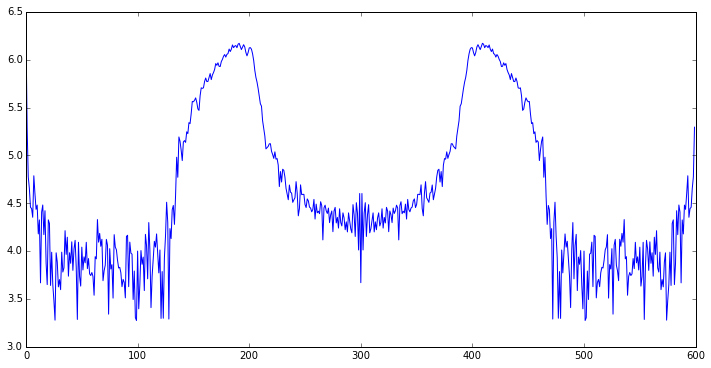

In [90]:
# full FFT output averaged for the data set
# needs to be quite flat above p = 200
plt.plot( np.log10(abs((np.average(VacCorrected,axis=(1,2)))) ))

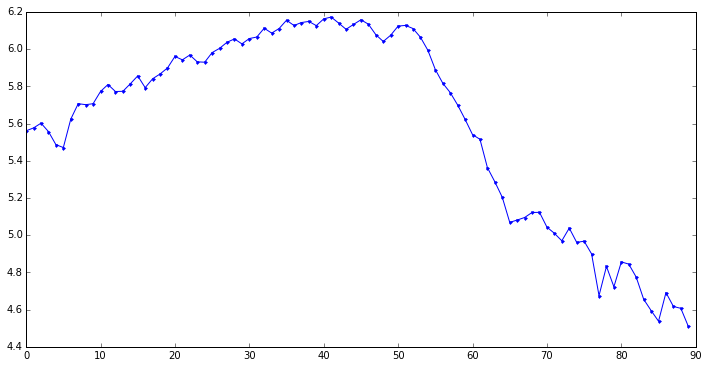

In [91]:
# look near the mode of interest (only useful for the strong-signal data)
plt.plot( np.log10(abs((np.average(VacCorrected,axis=(1,2)))) )[150:240],".-")

In [92]:
selectedMode = 190
output = (np.sqrt(2.0/ncount) * VacCorrected[selectedMode,:,:]).flatten('F')  
# Choose the mode to analyze, with n_t scaling

# output = VacCorrected[selectedMode,:,:].flatten()  # Choose the mode to analyze

Average amplitude: 238.944516


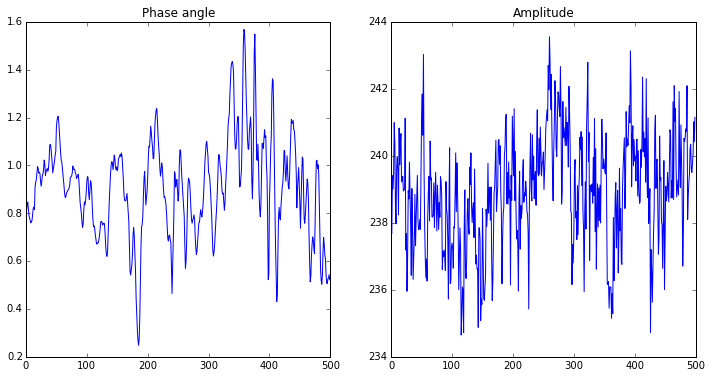

In [93]:
# Look at the average amplitude and a plot of phase angle and amplitude vs. shot number:
plt.subplot(121)
plt.plot(angle(output))
plt.title("Phase angle")
plt.subplot(122)
plt.plot(abs(output))
plt.title("Amplitude")
print "Average amplitude: %f" % np.average(abs(output))

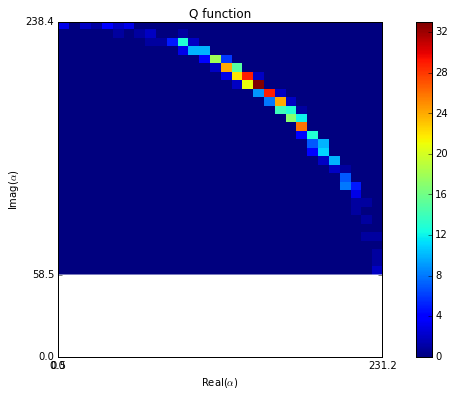

In [94]:
qfig = Qfunc.qfuncimage(output,30,0)

In [84]:
saveQfig()

15-49-51


# Use the following for shot noise measurement

Note, this is wrong, we need to create this plot for the mode we analyze. In other words, go through more of the analysis and plot var(Kp) vs mean(Kp) for a specific mode. Can modify this code!

In [124]:
sys.path.append('/home/photon/code/Instruments')
import instrument
import time

In [127]:
rigolDG = instrument.RigolDG("/dev/usbtmc0")

Rigol Technologies,DG4102,DG4B151400125,00.01.04



In [337]:
datapoints = 12
means = numpy.zeros((10,600,datapoints))
variances = numpy.zeros((10,600,datapoints))
powers = numpy.linspace(1,5,datapoints)
#print powers
shot = 0
for lo_power in powers:
    command = ":VOLT:HIGH %s" % lo_power
    #print command
    rigolDG.write(command)
    time.sleep(2)
    request_images(client,N=100)
    data = open_images()
    #pylab.imshow(data[:,:,50])
    #pylab.show()
    print "Collected shot number %g" % (shot)
    #summed = data.sum(axis=0)
    means[:,:,shot] = data.mean(axis=2)
    variances[:,:,shot] = data.var(axis=2)
    #pylab.imshow(variances[:,:,shot])
    #pylab.show()
    shot+=1
    
print "Finished"

I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 0
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 1
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 2
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 3
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 4
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 5
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 6
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 7
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 8
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 9
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 10
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 11
Finished


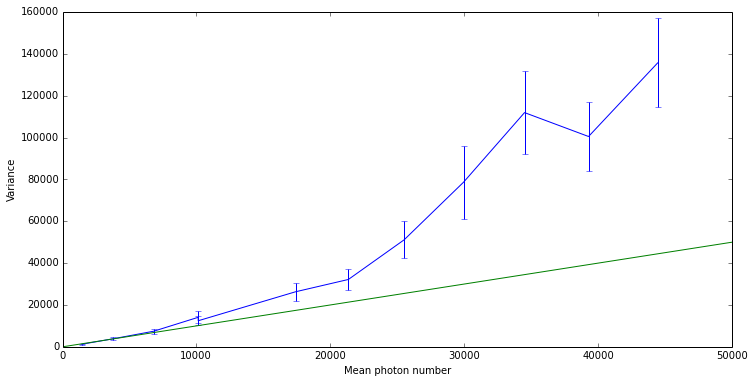

In [338]:
submeans = means[:,250:350,:]
subvars = variances[:,250:350,:]
x = submeans.mean(axis=(0,1))
y = subvars.mean(axis=(0,1))
yerr = subvars.std(axis=(0,1))
pylab.errorbar(x,y,yerr=yerr)
pylab.plot(numpy.arange(50000),numpy.arange(50000))
pylab.xlabel("Mean photon number")
pylab.ylabel("Variance")

In [214]:
from scipy import stats

In [339]:
slope, intercept, r_value, p_value, std_err = stats.linregress(submeans.flatten('F'),subvars.flatten('F'))
print slope
print std_err

3.17620871733
0.00943766085919


# Use the following to verify SNR

In [90]:
request_images(client,N=5)

I: Sending (5)


In [91]:
blocked = open_images()

I: Server replied OK: (10, 600, 5)


In [239]:
request_images(client,N=4)

I: Sending (4)


In [240]:
unblocked = open_images()

I: Server replied OK: (10, 600, 4)


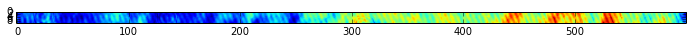

In [241]:
pylab.imshow(unblocked[:,:,:].mean(axis=2))

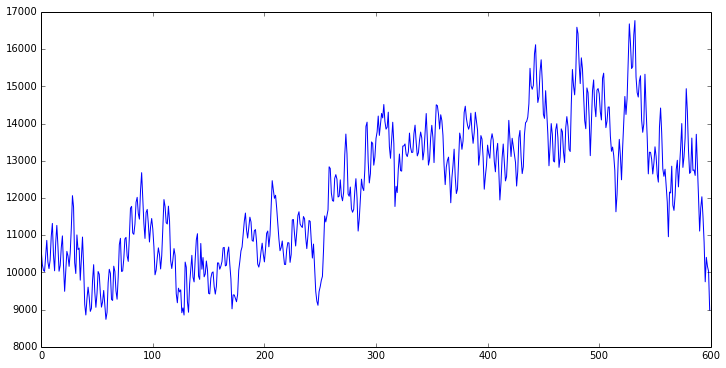

In [245]:
pylab.plot(unblocked[5,:,:].mean(axis=1))

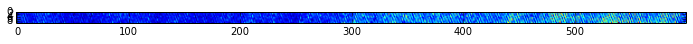

In [98]:
pylab.imshow(unblocked[:,:,:].var(axis=2))

In [104]:
snr = (unblocked-background).var(axis=2) / (blocked-background).var(axis=2)

In [105]:
snr.mean()

992.96047592928085

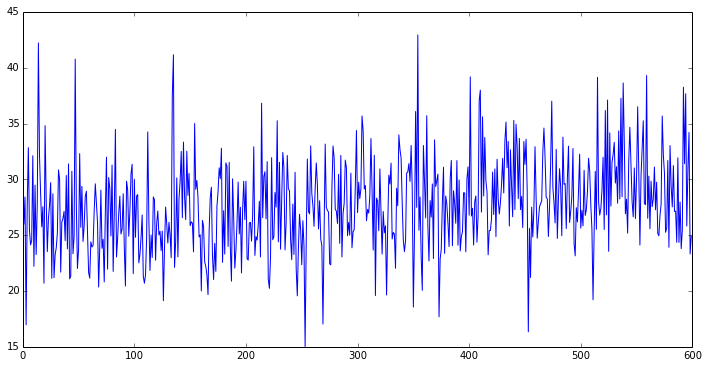

In [106]:
pylab.plot(10*np.log10(snr[5,:]))

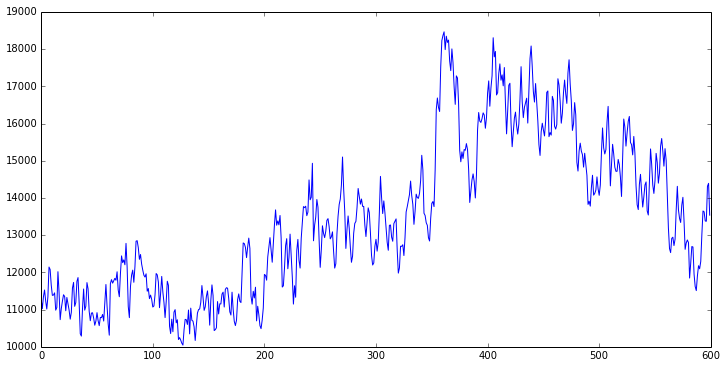

In [35]:
pylab.plot((unblocked-background)[5,:,0])